In [ ]:
# find the top growing suburbs
# using past changes and population stats

In [322]:
import pandas as pd
from ast import literal_eval
import statistics
from tqdm import tqdm
import numpy as np
import pandas as pd
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
from matplotlib import pyplot as plt
import numpy as np
from sklearn import metrics

In [323]:
df = pd.read_csv('../data/curated/full_listing.csv')

In [324]:
df.columns

Index(['Unnamed: 0', 'bed', 'bath', 'car', 'type', 'address', 'suburb',
       'postcode', 'url', 'loc_address', 'lat', 'lon', 'weekly_rent',
       'list_date', 'list_history', 'list_count', 'SA2_NAME_2016', 'SA2',
       'lgaregion', 'income_earner', 'income_median_age', 'income_median',
       'income_mean', 'income_top_10_pct', 'population_total',
       'population_children', 'population_prime_working', 'population_elderly',
       'population_early_working', 'population_mature_working',
       'primary_school_name', 'secondary_school_name', 'secondary_school_rank',
       'secondary_school_cohort', 'pri_lat', 'pri_lon', 'sec_lat', 'sec_lon',
       'proj_population_total', 'proj_population_children',
       'proj_population_early_working', 'proj_population_prime_working',
       'proj_population_mature_working', 'proj_population_elderly',
       'closest_ed_name', 'ed_lat', 'ed_lon', 'train_stop', 'train_n_lines',
       'train_lat', 'train_lon', 'primary_distance', 'primary_dura

In [325]:
keep_columns = ['address', 'list_history', 'population_total', 'proj_population_total', 'population_children', 'proj_population_children', 'population_early_working', 'proj_population_early_working', 'population_mature_working', 'proj_population_mature_working', 'population_prime_working', 'proj_population_prime_working', 'population_elderly', 'proj_population_elderly']

In [326]:
df = df[keep_columns]

In [327]:
df.head()

,address,list_history,population_total,proj_population_total,population_children,proj_population_children,population_early_working,proj_population_early_working,population_mature_working,proj_population_mature_working,population_prime_working,proj_population_prime_working,population_elderly,proj_population_elderly
0,". GLYNDON ROAD, CAMBERWELL","[[-0.08487511721664373, 0.504297994269341], [-...",21512,25643,3506,4215,3069,4019,2712,2937,7721,9588,4504,4884
1,"1 NEVIS STREET, CAMBERWELL","[[-0.08487511721664373, -0.05063291139240506],...",21512,25643,3506,4215,3069,4019,2712,2937,7721,9588,4504,4884
2,"1/10 GLENCAIRN AVENUE, CAMBERWELL","[[-7.915289157203776, 0.06756756756756757]]",21512,25643,3506,4215,3069,4019,2712,2937,7721,9588,4504,4884
3,"1/1017 TOORAK ROAD, CAMBERWELL","[[-2.4120960731568752, 0.008695652173913044], ...",21512,25643,3506,4215,3069,4019,2712,2937,7721,9588,4504,4884
4,"1/11 EDDY STREET, CAMBERWELL","[[-5.497717270032924, 0.02564102564102564], [-...",21512,25643,3506,4215,3069,4019,2712,2937,7721,9588,4504,4884


In [328]:
n_rows = len(df)
n_cols = len(df.iloc[0])

In [329]:
n_rows

41978

In [330]:
# increase rate = (newer rent - older rent) / older amount / year difference
result = []
for i in tqdm(range(n_rows)):
    temp = []
    record_list = literal_eval(df.iloc[i]['list_history'])
    if len(record_list) > 0:
        for j in record_list:
            temp.append(j[1]/j[0])
        temp = [statistics.mean(temp)]
    else:
        temp = []
    for j in range(2, n_cols, 2):
        temp.append((df.iloc[i][j + 1] - df.iloc[i][j]) / df.iloc[i][j] /5)
    result.append(temp)

 96%|█████████▌| 40237/41978 [00:30<00:01, 1337.96it/s]/var/folders/y5/myhyydfd6h9dlwv1qmqtqhmr0000gn/T/ipykernel_47529/4265992499.py:13: RuntimeWarning: divide by zero encountered in long_scalars
  temp.append((df.iloc[i][j + 1] - df.iloc[i][j]) / df.iloc[i][j] /5)
/var/folders/y5/myhyydfd6h9dlwv1qmqtqhmr0000gn/T/ipykernel_47529/4265992499.py:13: RuntimeWarning: invalid value encountered in long_scalars
  temp.append((df.iloc[i][j + 1] - df.iloc[i][j]) / df.iloc[i][j] /5)
100%|██████████| 41978/41978 [00:31<00:00, 1337.43it/s]


In [331]:
df = pd.read_csv('../data/curated/full_listing.csv').iloc[:,1:]

In [332]:
df = df.drop(keep_columns[1:], axis = 1)

In [333]:
df2 = pd.DataFrame(result, columns = ['c_rent', 'c_total_population', 'c_children', 'c_early', 'c_mature', 'c_prime', 'c_elderly'])

In [334]:
result_df = pd.concat([df, df2], axis=1)

In [335]:
result_df

,bed,bath,car,type,address,suburb,postcode,url,loc_address,lat,...,train_duration,melb_distance,melb_duration,c_rent,c_total_population,c_children,c_early,c_mature,c_prime,c_elderly
0,3,1,2,AUF,". GLYNDON ROAD, CAMBERWELL",Camberwell,3124,https://www.oldlistings.com.au/real-estate/VIC...,"Glyndon Road, Camberwell, Melbourne, City of B...",-37.836230,...,189,14572,1508,-2.831684,0.038406,0.040445,0.061909,0.016593,0.048362,0.016874
1,4,2,3,AUF,"1 NEVIS STREET, CAMBERWELL",Camberwell,3124,https://www.oldlistings.com.au/real-estate/VIC...,"Nevis Street, Camberwell, Melbourne, City of B...",-37.843101,...,197,13778,1423,0.277021,0.038406,0.040445,0.061909,0.016593,0.048362,0.016874
2,2,1,1,AUF,"1/10 GLENCAIRN AVENUE, CAMBERWELL",Camberwell,3124,https://www.oldlistings.com.au/real-estate/VIC...,"Glencairn Avenue, Camberwell, Melbourne, City ...",-37.848191,...,87,13262,1372,-0.008536,0.038406,0.040445,0.061909,0.016593,0.048362,0.016874
3,3,2,2,House,"1/1017 TOORAK ROAD, CAMBERWELL",Camberwell,3124,https://www.oldlistings.com.au/real-estate/VIC...,"Toorak Road, Camberwell, Melbourne, City of Bo...",-37.850405,...,190,14435,1464,0.058927,0.038406,0.040445,0.061909,0.016593,0.048362,0.016874
4,2,1,1,House,"1/11 EDDY STREET, CAMBERWELL",Camberwell,3124,https://www.oldlistings.com.au/real-estate/VIC...,"Eddy Street, Camberwell, Melbourne, City of Bo...",-37.846792,...,114,12502,1288,-0.006807,0.038406,0.040445,0.061909,0.016593,0.048362,0.016874
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41973,3,1,1,NaN,"1486 BOLINDA ROAD, DARRAWEIT GUIM",Darraweit Guim,3756,https://www.oldlistings.com.au/real-estate/VIC...,"Bolinda - Darraweit Road, Bolinda, Shire of Ma...",-37.438871,...,1846,59224,3379,-0.023067,0.020975,0.034746,0.041955,0.009543,0.003970,0.040751
41974,3,1,2,NaN,"2264 WHITTLESEA-YEA ROAD, HAZELDENE",Hazeldene,3658,https://www.oldlistings.com.au/real-estate/VIC...,"Whittlesea - Yea Road, Flowerdale, Hazeldene, ...",-37.342711,...,2512,80857,4432,-0.079057,-0.008402,0.009187,0.033149,-0.059975,-0.031054,0.028547
41975,3,2,4,NaN,"3041 BROADFORD-FLOWERDALE ROAD, FLOWERDALE",Flowerdale,3658,https://www.oldlistings.com.au/real-estate/VIC...,"Broadford - Flowerdale Road, Flowerdale, Shire...",-37.312564,...,3063,92781,4983,-0.360912,-0.008402,0.009187,0.033149,-0.059975,-0.031054,0.028547
41976,5,2,3,NaN,"235 PARWAN EXFORD ROAD, PARWAN",Parwan,3340,https://www.oldlistings.com.au/real-estate/VIC...,"Parwan Exford Road, Parwan, Melbourne, City of...",-37.725486,...,2053,61299,3249,-0.015679,0.001561,-0.010811,-0.010742,-0.003132,-0.026886,0.084396


In [336]:
remove = ['address', 'postcode', 'url', 'loc_address', 'lat', 'lon', 'list_date', 'SA2_NAME_2016', 'SA2', 'lgaregion', 'primary_school_name', 'secondary_school_name', 'pri_lat', 'pri_lon', 'sec_lat', 'sec_lon', 'closest_ed_name', 'ed_lat', 'ed_lon', 'train_stop', 'train_lat', 'train_lon']
result_df = result_df.drop(remove, axis = 1)

In [337]:
result_df.type = pd.Categorical(df.type)
result_df['type_code'] = result_df.type.cat.codes
result_df = result_df.dropna()

In [338]:
result_df

,bed,bath,car,type,suburb,weekly_rent,list_count,income_earner,income_median_age,income_median,...,melb_distance,melb_duration,c_rent,c_total_population,c_children,c_early,c_mature,c_prime,c_elderly,type_code
0,3,1,2,AUF,Camberwell,525.0,2,14501.0,47.0,61520.0,...,14572,1508,-2.831684,0.038406,0.040445,0.061909,0.016593,0.048362,0.016874,0
1,4,2,3,AUF,Camberwell,850.0,2,14501.0,47.0,61520.0,...,13778,1423,0.277021,0.038406,0.040445,0.061909,0.016593,0.048362,0.016874,0
2,2,1,1,AUF,Camberwell,395.0,1,14501.0,47.0,61520.0,...,13262,1372,-0.008536,0.038406,0.040445,0.061909,0.016593,0.048362,0.016874,0
3,3,2,2,House,Camberwell,580.0,5,14501.0,47.0,61520.0,...,14435,1464,0.058927,0.038406,0.040445,0.061909,0.016593,0.048362,0.016874,1
4,2,1,1,House,Camberwell,400.0,3,14501.0,47.0,61520.0,...,12502,1288,-0.006807,0.038406,0.040445,0.061909,0.016593,0.048362,0.016874,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41967,3,1,2,House,Upper Ferntree Gully,420.0,1,9344.0,42.0,52396.0,...,38068,2541,0.274000,0.004738,0.002893,-0.003866,-0.006521,0.003263,0.026573,1
41968,3,2,2,House,Upper Ferntree Gully,430.0,2,9344.0,42.0,52396.0,...,41252,2658,-0.070807,0.004738,0.002893,-0.003866,-0.006521,0.003263,0.026573,1
41969,3,1,1,House,Upper Ferntree Gully,420.0,3,9344.0,42.0,52396.0,...,41271,2680,-0.009996,0.004738,0.002893,-0.003866,-0.006521,0.003263,0.026573,1
41970,3,1,1,House,Upper Ferntree Gully,365.0,4,9344.0,42.0,52396.0,...,40536,2629,-0.130107,0.004738,0.002893,-0.003866,-0.006521,0.003263,0.026573,1


In [339]:
X = result_df.drop(['type', 'suburb', 'c_rent'], axis=1)
y = result_df['c_rent']

In [340]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

In [341]:
result_df = result_df.dropna()

In [342]:
reg = RandomForestRegressor(n_estimators = 500, random_state = 0).fit(X, y)

In [343]:
predictions = reg.predict(X)
gt = y.tolist()
print('Mean Absolute Error (MAE):', round(metrics.mean_absolute_error(gt, predictions), 4))
print('Mean Squared Error (MSE):', round(metrics.mean_squared_error(gt, predictions), 4))
print('Root Mean Squared Error (RMSE):', round(np.sqrt(metrics.mean_squared_error(gt, predictions)), 4))
mape = np.mean(np.abs((gt - predictions) / np.abs(gt)))
print('Mean Absolute Percentage Error (MAPE):', round(mape * 100, 4))
print('Accuracy:', round(100 * (1 - mape), 4))
print('R-squared:', round(metrics.r2_score(gt, predictions), 4))

Mean Absolute Error (MAE): 0.0256
Mean Squared Error (MSE): 0.0066
Root Mean Squared Error (RMSE): 0.0814
Mean Absolute Percentage Error (MAPE): inf
Accuracy: -inf
R-squared: 0.848


/var/folders/y5/myhyydfd6h9dlwv1qmqtqhmr0000gn/T/ipykernel_47529/2637976319.py:6: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((gt - predictions) / np.abs(gt)))


/Users/nhe/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0, 0.5, 'predicted rental price')

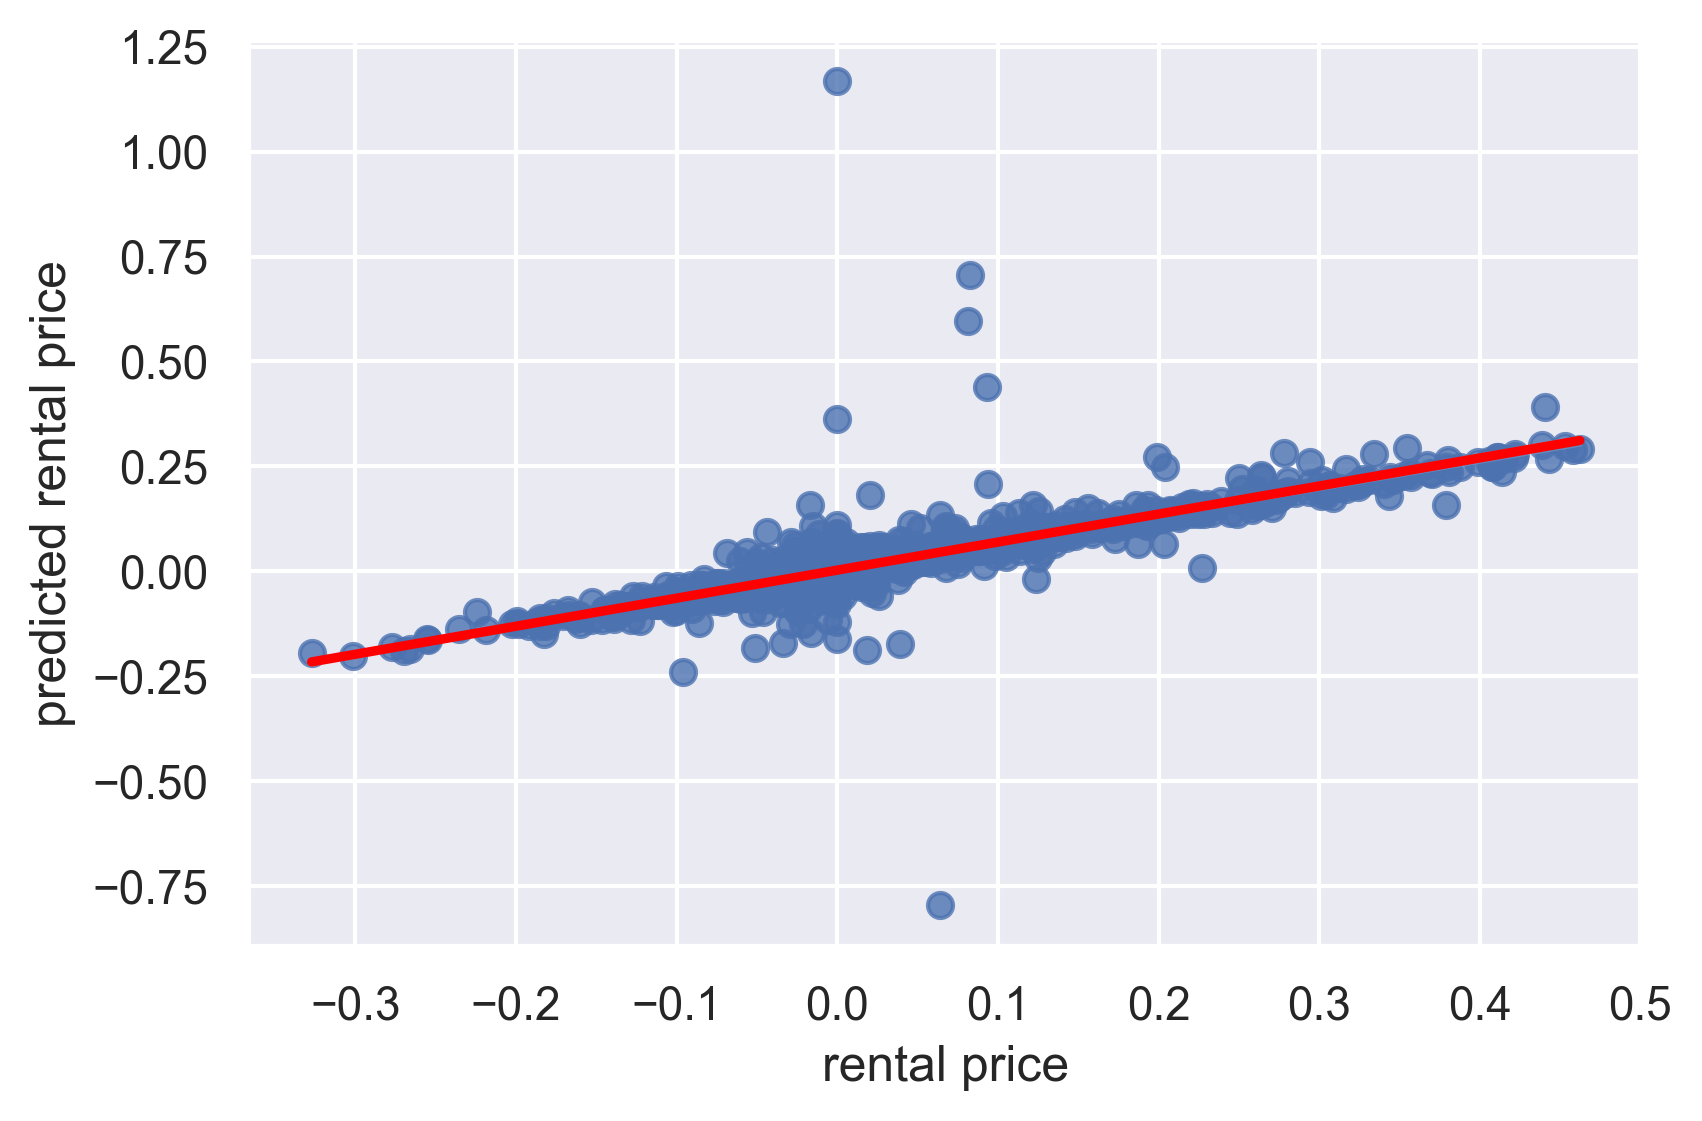

In [344]:
compare_df = pd.DataFrame({'gt': y.tolist(), 'prediction': predictions.tolist()})
compare_df = compare_df[compare_df['gt'] <= y.quantile(0.99)]
compare_df = compare_df[compare_df['gt'] >= y.quantile(0.01)]
sample = compare_df.sample(n=3000)
import seaborn as sns
sns.set(rc={"figure.dpi": 300, 'savefig.dpi': 300})
sns_plot = sns.regplot(sample['gt'], sample['prediction'], line_kws={"color": "red"})
sns_plot.set_xlabel('rental price')
sns_plot.set_ylabel('predicted rental price')

In [345]:
rank_df = result_df.groupby('suburb').mean()

/var/folders/y5/myhyydfd6h9dlwv1qmqtqhmr0000gn/T/ipykernel_47529/4155057459.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  rank_df = result_df.groupby('suburb').mean()


In [347]:
rank_df[['bed', 'bath', 'car', 'type_code']] = [2, 1, 1, 4]

,bed,bath,car,weekly_rent,list_count,income_earner,income_median_age,income_median,income_mean,income_top_10_pct,...,melb_distance,melb_duration,c_rent,c_total_population,c_children,c_early,c_mature,c_prime,c_elderly,type_code
suburb,,,,,,,,,,,,,,,,,,,,,
Abbotsford,2,1,1,469.664804,2.765363,6589.0,33.0,64090.0,78181.0,30.2,...,4131.005587,793.256983,0.021945,0.137594,0.201581,0.119558,0.172872,0.130986,0.117633,4
Airport West,2,1,1,446.428571,2.428571,4842.0,41.0,58506.0,65204.0,25.9,...,16369.298701,1228.766234,0.064020,0.022095,0.018497,0.027297,0.023857,0.019239,0.028352,4
Albanvale,2,1,1,360.200000,2.440000,6608.0,39.0,44383.0,46226.0,24.0,...,28514.240000,1998.040000,0.007087,0.019501,0.017093,-0.000908,-0.009484,0.021493,0.052895,4
Albert Park,2,1,1,757.187500,3.968750,11685.0,44.0,67518.0,120412.0,48.3,...,5991.437500,980.812500,0.008902,0.037271,0.041663,0.071020,0.037916,0.022553,0.054104,4
Albion,2,1,1,324.217391,2.195652,4479.0,35.0,44333.0,50078.0,26.4,...,14660.326087,1678.978261,0.002349,0.077314,0.137489,0.099490,0.033524,0.077477,0.027740,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Yan Yean,2,1,1,460.000000,1.000000,4855.0,45.0,51318.0,62590.0,29.5,...,41487.000000,3196.000000,0.000000,-0.006104,-0.024056,-0.000605,0.029178,-0.024594,0.034363,4
Yarra Glen,2,1,1,397.000000,4.600000,8182.0,46.0,47104.0,57853.0,30.9,...,54577.200000,3494.200000,-0.021911,0.028136,0.026515,0.038148,0.014665,0.021594,0.044197,4
Yarra Junction,2,1,1,414.333333,3.266667,9341.0,45.0,46606.0,53041.0,27.0,...,68924.666667,4331.866667,-0.050801,0.010692,0.022056,0.017396,-0.013810,-0.000316,0.036809,4


In [350]:
x = rank_df.drop('c_rent', axis=1).dropna()
prediction = pd.DataFrame({'suburb': x.index.tolist(), 'grow': reg.predict(x)}).sort_values(by='grow', ascending=False)

In [358]:
stats_df = prediction.merge(df.groupby('suburb').count().iloc[:,0], on = 'suburb')
stats_df = stats_df.set_axis(['suburb', 'growth_rate', 'n_listing'], axis=1)
min_listing = stats_df.n_listing.quantile(0.25)
stats_df = stats_df.loc[stats_df['n_listing'] >= min_listing]

In [360]:
stats_df.head(10)

,suburb,growth_rate,n_listing
1,Travancore,0.164745,63
6,Bentleigh,0.061007,199
9,Airport West,0.047849,122
10,Caulfield East,0.039269,75
11,Beaumaris,0.035759,53
12,Delahey,0.034607,46
15,Carlton,0.032650,382
16,Coburg North,0.029456,81
18,Strathmore,0.026577,43
19,Essendon West,0.026516,18


<BarContainer object of 30 artists>

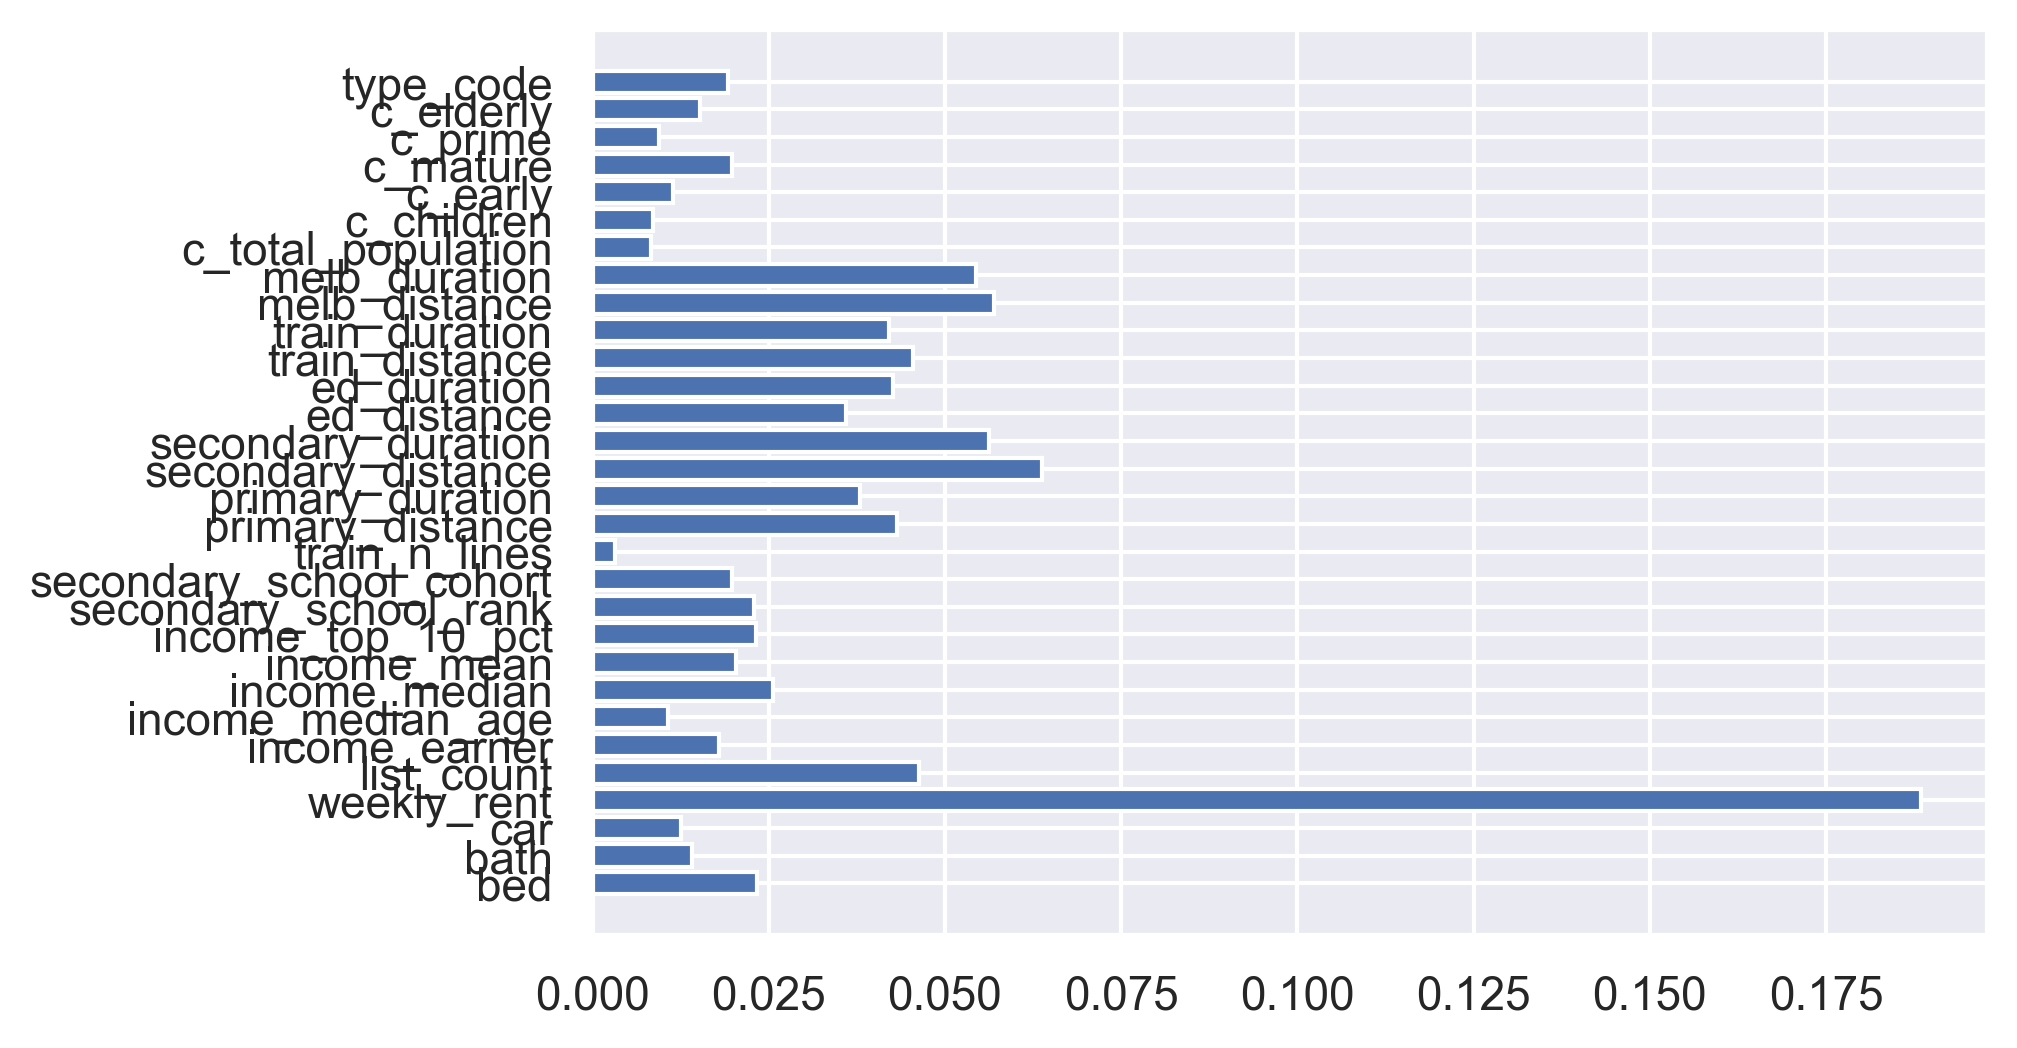

In [361]:
plt.barh(x.columns, reg.feature_importances_)

In [372]:
pd.DataFrame({'feature_name': x.columns, 'feature_imporance': reg.feature_importances_}).sort_values(by='feature_imporance', ascending=False).head()

,feature_name,feature_imporance
3,weekly_rent,0.188465
15,secondary_distance,0.063842
21,melb_distance,0.056989
16,secondary_duration,0.056257
22,melb_duration,0.054492


In [210]:
#
# >>> reg.score(X, y)
# 1.0
# >>> reg.coef_
# array([1., 2.])
# >>> reg.intercept_
# 3.0...
# >>> reg.predict(np.array([[3, 5]]))
# array([16.])

In [211]:
# len(df) == len(df2)

In [212]:
# len(result)

In [213]:
# result_df =